# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Luca Mainardi]
### Member 2: [Francesco Brescia]
### Member 3: [Matthew Nana]

In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle


In [ ]:
# Variable to enable/disable training
TRAIN = False

In [38]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [39]:
train_data = load_data('data/train_data.pkl')

In [40]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [41]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)
    
    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 640x480 with 0 Axes>

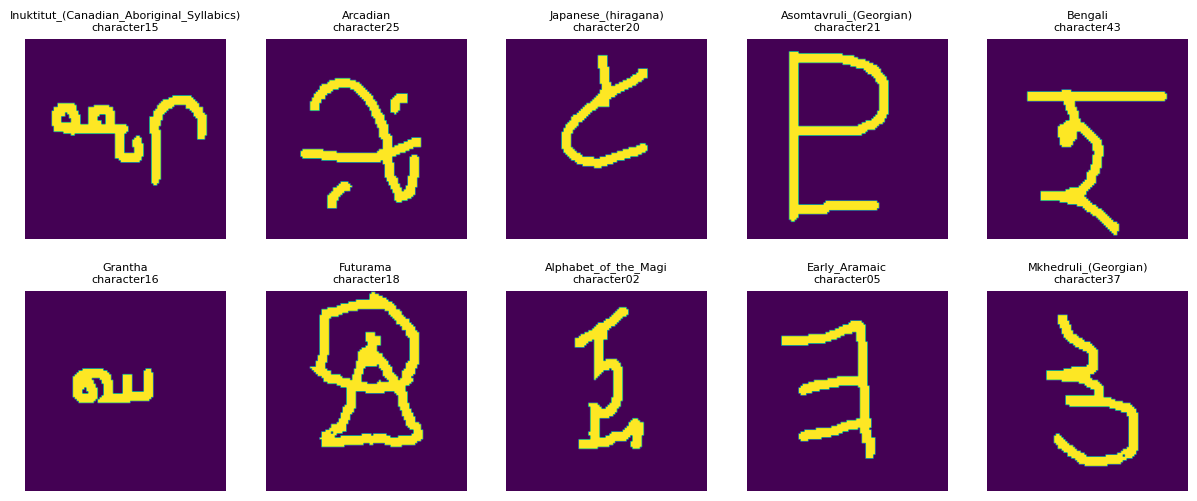

In [42]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [43]:
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [44]:
# import torch
# from torch.utils.data import Dataset
# from sklearn.preprocessing import LabelEncoder

# class MyDataset(Dataset):
#     def __init__(self, data_dict):

#         self.images = []
#         self.labels = []
#         self.encoder = LabelEncoder()

#         for alphabet in data_dict.keys():
#             characters = data_dict[alphabet]
#             for character in characters.keys():
#                 images = characters[character]
#                 self.images.extend(images)
#                 self.labels.extend([f"{alphabet} {character}"] * len(images))

#         self.labels = self.encoder.fit_transform(self.labels)

#     def __len__(self):
#         # l = 0
#         # for alphabet in train_data.keys():
#         #     characters = train_data[alphabet]
#         #     for character in characters.keys():
#         #         images = characters[character]
#         #         l += len(images)
#         # return l
#         return len(self.images)
        
#     def __getitem__(self, idx):

#         if idx >= len(self):
#             raise IndexError
        
#         image = self.images[idx]
#         # clone the channels to have 3 channels
#         image = torch.cat([image, image, image], dim=0)
#         label = self.labels[idx]

#         assert image.shape == (3, 105, 105)

#         # make image smaller in size TODO
#         image = nn.functional.interpolate(image.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=True).squeeze(0)
        

#         return image, label
#         # for alphabet in train_data.keys():
#         #     characters = train_data[alphabet]
#         #     for character in characters.keys():
#         #         images = characters[character]
#         #         if idx < len(images):
#         #             image = images[idx]
#         #             return image, f"{alphabet} {character}"
#         #         idx -= len(images)
        

In [45]:
# Instantiate the dataset
# trainset = MyDataset(train_data)

In [46]:
# len(trainset)

In [47]:
# trainset[0]

In [48]:
# # plot some images from the dataset
# plt.figure(figsize=(15, 6))
# for i in range(10):
#     image, label = trainset[i]
#     plt.subplot(2, 5, i+1)
#     plt.imshow(image.permute(1, 2, 0))
#     plt.title(label)
#     plt.axis('off')

In [49]:
# num_classes = len(set(trainset.labels))
# num_classes

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split
import os

In [51]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [85]:

# Siamese Network definition
class SiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = self.get_feature_extractor(pretrained)
        self.fc = nn.Linear(512, 128)

    def get_feature_extractor(self, pretrained):
        resnet = resnet18(pretrained=pretrained)
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        return feature_extractor

    def forward_one(self, x):
        return self.feature_extractor(x).squeeze()

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        return output1, output2

# Siamese Dataset definition
# class SiameseDataset(Dataset):
#     def __init__(self, data_dict, transform=None):
        
#         self.images = []
#         self.labels = []
#         self.transform = transform
#         self.encoder = LabelEncoder()

#         for alphabet in data_dict.keys():
#             characters = data_dict[alphabet]
#             for character in characters.keys():
#                 images = characters[character]
#                 self.images.extend(images)
#                 self.labels.extend([f"{alphabet} {character}"] * len(images))

#         self.labels = self.encoder.fit_transform(self.labels)


#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):

#         img1 = self.images[idx]
#         img1 = img1.repeat(3, 1, 1)
#         # print(type(img1))
        
#         if self.transform:
#             #img1 = Image.fromarray(img1)
#             to_pil = transforms.ToPILImage()
#             img1 = to_pil(img1)
#             img1 = self.transform(img1)  
#             print(type(img1))
#             # img1 = img1.permute(1, 2, 0).cpu().numpy()

#         label1 = self.labels[idx]

#         # Sample a random image from the same class
#         class_images = []
#         for i, label in enumerate(self.labels):
#             if label == label1:
#                 class_images.append(self.images[i])

#         img2 = class_images[np.random.choice(len(class_images))]
#         img2 = img2.repeat(3, 1, 1)

#         if self.transform:
#             # img2 = Image.fromarray(img2)
#             to_pil = transforms.ToPILImage()
#             img2 = to_pil(img2)
#             img2 = self.transform(img2)
#             print(type(img2))
#             # img2 = img2.permute(1, 2, 0).cpu().numpy()

#         return img1, img2, torch.tensor(label1)

class SiameseDataset(Dataset):
    def __init__(self, data_dict, transform=None):

        np.random.seed(42)
        
        self.images = []
        self.labels = []
        self.transform = transform
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)

        # Create list with all possible pairs of images with same label
        self.pairs = []
        self.pairs_labels = []
        for i in range(len(self.images)):
            for j in range(i+1, len(self.images)):
                if self.labels[i] == self.labels[j]:
                    self.pairs.append((self.images[i], self.images[j]))
                    self.pairs_labels.append(1)

        # sample the same number of pairs with different labels
        pairs_with_diff_labels = []
        while len(pairs_with_diff_labels) < len(self.pairs):
            i, j = np.random.choice(len(self.images), size=2, replace=False,  )
            if self.labels[i] != self.labels[j]:
                pairs_with_diff_labels.append((self.images[i], self.images[j]))

        self.pairs.extend(pairs_with_diff_labels)
        self.pairs_labels.extend([0] * len(pairs_with_diff_labels))

        
        # for i in range(len(self.images)):
        #     for j in range(i+1, len(self.images)):
        #         if self.labels[i] != self.labels[j]:
        #             self.pairs.append((self.images[i], self.images[j]))
        #             self.pairs_labels.append(0)

        # # Create list with all possible pairs of images
        # self.pairs = []
        # self.pairs_labels = []
        # for i in range(len(self.images)):
        #     for j in range(i+1, len(self.images)):
        #         self.pairs.append((self.images[i], self.images[j]))
        #         self.pairs_labels.append(1 if self.labels[i] == self.labels[j] else 0)

        # # Convert pairs and pairs_labels to numpy arrays for easier manipulation
        # self.pairs = np.array(self.pairs)
        # self.pairs_labels = np.array(self.pairs_labels)

        # # Get indices of pairs with label 0 and label 1
        # idx0 = np.where(self.pairs_labels == 0)[0]
        # idx1 = np.where(self.pairs_labels == 1)[0]

        # # Randomly select instances of label 0 to make the classes balanced
        # np.random.shuffle(idx0)
        # idx0_balanced = idx0[:len(idx1)]

        # # Concatenate the balanced label 0 indices with the label 1 indices
        # idx_balanced = np.concatenate([idx0_balanced, idx1])

        # # Use the balanced indices to select the pairs and pairs_labels
        # self.pairs = self.pairs[idx_balanced]
        # self.pairs_labels = self.pairs_labels[idx_balanced]

        


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img1, img2 = self.pairs[idx]

        img1 = img1.repeat(3, 1, 1)
        img2 = img2.repeat(3, 1, 1)
        label = self.pairs_labels[idx]
        
        if self.transform:
            to_pil = transforms.ToPILImage()
            img1 = to_pil(img1)
            img1 = self.transform(img1)  
            img2 = to_pil(img2)
            img2 = self.transform(img2)

        return img1, img2, label




# # Function to load and preprocess images
# def load_image(image_path):
#     image = Image.open(image_path).convert('RGB')
#     preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     return preprocess(image)

# Function to create Siamese dataset
def create_siamese_dataset(data_dict, transform=None):
    return SiameseDataset(data_dict=data_dict, transform=transform)

# Function to train Siamese network
def train_siamese_network(siamese_network, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        siamese_network.train()

        running_loss = 0.0
        running_accuracy = 0.0
        batch_count = 0

        for img1, img2, label in progress_bar:
            optimizer.zero_grad()
            output1, output2 = siamese_network(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy = compute_accuracy(output1.detach(), output2.detach(), label)
            running_accuracy += accuracy
            batch_count += 1

            # Update the progress bar with the current loss and accuracy
            progress_bar.set_postfix({"loss": running_loss / batch_count, "accuracy": running_accuracy / batch_count})


        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")

        # Validation
        progress_bar = tqdm(val_loader, desc=f"Val Epoch {epoch + 1}")
        siamese_network.eval()
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        batch_count = 0

        with torch.no_grad():
            for img1, img2, label in progress_bar:
                output1, output2 = siamese_network(img1, img2)
                val_loss = criterion(output1, output2, label)
                running_val_loss += val_loss.item()
                val_accuracy = compute_accuracy(output1.detach(), output2.detach(), label)
                running_val_accuracy += val_accuracy
                batch_count += 1

                # Update the progress bar with the current loss and accuracy
                progress_bar.set_postfix({"val_loss": running_val_loss / batch_count, "val_accuracy": running_val_accuracy / batch_count})

        print(f"Val Epoch {epoch+1}, Loss: {running_val_loss/len(val_loader)}, Accuracy: {running_val_accuracy/len(val_loader)}")

# Function to compute similarity between images
# def compute_similarity(siamese_network, image1, image2):
#     embedding1, embedding2 = siamese_network.forward(image1.unsqueeze(0), image2.unsqueeze(0))

#     print(embedding1.shape)
#     print(embedding2.shape)

#     similarity = torch.cosine_similarity(embedding1, embedding2, dim=1)
#     return similarity.item()

# Function to compute accuracy of the Siamese network
def compute_accuracy(output1, output2, label, threshold=0.5):
    # Compute the Euclidean distance between output1 and output2
    distance = (output1 - output2).pow(2).sum(1).sqrt()
    # Compute the predictions: if distance < threshold, predict 'same class' (1), else 'different class' (0)
    predictions = (distance < threshold).float()
    # Compute the accuracy by comparing predictions with the true labels
    accuracy = (predictions == label).float().mean()
    return accuracy.item()


# unlabeled_image1_path = 'path_to_unlabeled_image1.jpg'
# unlabeled_image2_path = 'path_to_unlabeled_image2.jpg'
# image1 = load_image(unlabeled_image1_path)
# image2 = load_image(unlabeled_image2_path)
# similarity = compute_similarity(siamese_network, image1, image2)
# print("Similarity between images:", similarity)


In [59]:
# Define preprocessing steps
preprocess = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [60]:
# Create Siamese network and dataset
siamese_network = SiameseNetwork(pretrained=True)

siamese_dataset = create_siamese_dataset(train_data, transform=preprocess)

# Define the size of the validation set
val_size = int(0.2 * len(siamese_dataset))  # 20% of the dataset
train_size = len(siamese_dataset) - val_size

# Create train and validation sets
generator = torch.Generator().manual_seed(42)
siamese_train_dataset, siamese_val_dataset = random_split(siamese_dataset, [train_size, val_size], generator=generator)

# Create data loaders
train_loader = DataLoader(siamese_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(siamese_val_dataset, batch_size=32, shuffle=False)

print(f"Num of training pairs: {len(siamese_train_dataset)}")
print(f"Num of validation pairs: {len(siamese_val_dataset)}")

/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num of training pairs: 293056
Num of validation pairs: 73264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '0')

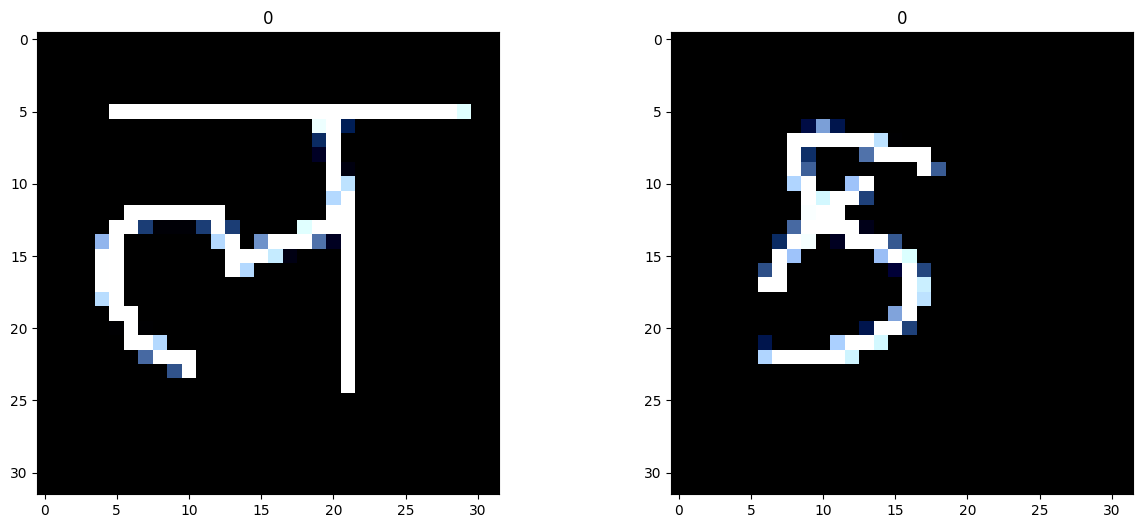

In [61]:
# Plot some random pairs of images from the dataset with their labels
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(len(siamese_dataset))
img1, img2, label = siamese_dataset[random_idx]
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title(label)
plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))
plt.title(label)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '1')

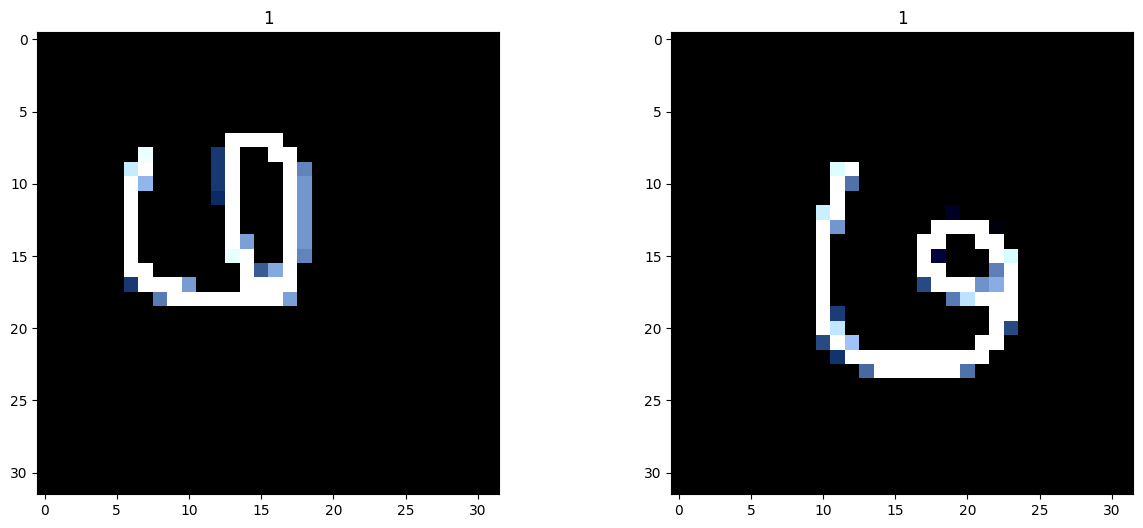

In [62]:
# Plot some images with label == 1
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(np.where(np.array(siamese_dataset.pairs_labels) == 1)[0])
img1, img2, label = siamese_dataset[random_idx]
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title(label)
plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))
plt.title(label)


In [64]:
# Train the Siamese network
if TRAIN:
    train_siamese_network(siamese_network, train_loader, val_loader, num_epochs=1, learning_rate=0.01)
    # Save the trained Siamese network
    torch.save(siamese_network.state_dict(), 'siamese_network.pth')

Epoch 1: 100%|██████████| 9158/9158 [1:36:24<00:00,  1.58it/s, loss=0.534, accuracy=0.516]


Epoch 1, Loss: 0.5344102741911646, Accuracy: 0.5163927713474558


Val Epoch 1: 100%|██████████| 2290/2290 [14:11<00:00,  2.69it/s, val_loss=0.308, val_accuracy=0.501]

Val Epoch 1, Loss: 0.30780899606026935, Accuracy: 0.501078056768559


In [65]:
# Load the trained Siamese network
siamese_network = SiameseNetwork()
siamese_network.load_state_dict(torch.load('siamese_network.pth'))

/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


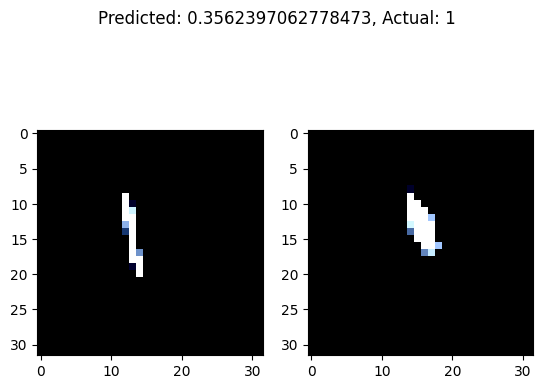

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


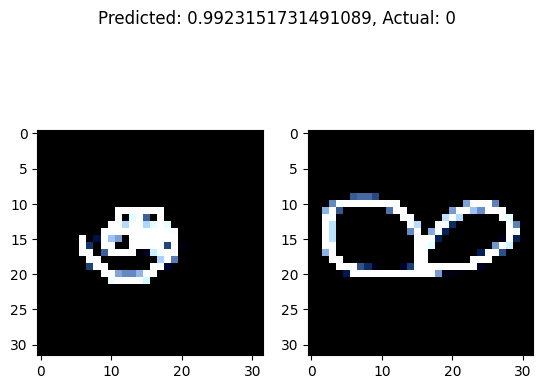

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


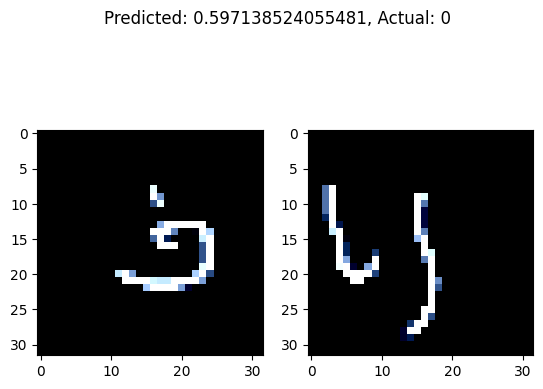

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


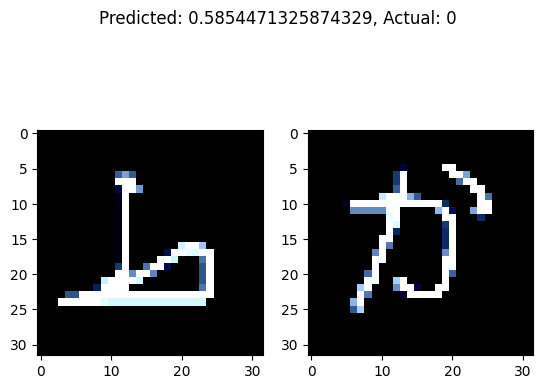

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


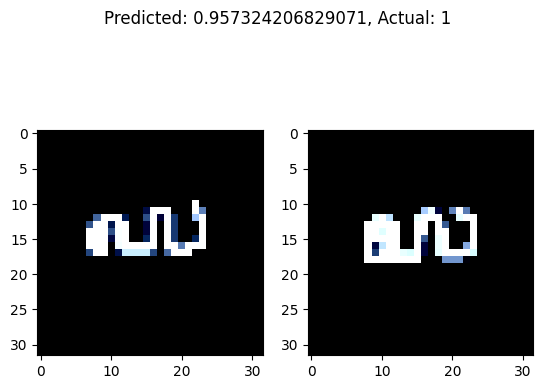

In [101]:
import matplotlib.pyplot as plt
import random
import itertools

# Test the trained Siamese network on some random pairs of images
def visualize_predictions(siamese_network, val_loader, num_pairs=5):
    siamese_network.eval()
    for i in range(num_pairs):
        # Create a new iterator for the validation loader
        dataiter = iter(val_loader)
        # Select a random batch
        batch_idx = random.randint(0, len(val_loader)-1)
        # Reset the iterator and advance to the random batch
        dataiter = itertools.islice(dataiter, batch_idx, None)
        img1, img2, label = next(dataiter)

        output1, output2 = siamese_network(img1, img2)
        cosine_similarity = nn.functional.cosine_similarity(output1, output2)
        predicted_label = cosine_similarity
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img1[0].numpy().transpose((1, 2, 0)))
        ax2.imshow(img2[0].numpy().transpose((1, 2, 0)))
        fig.suptitle(f"Predicted: {predicted_label[0]}, Actual: {label[0].item()}")
        plt.show()

visualize_predictions(siamese_network, val_loader)


In [183]:
# from torchvision.models import resnet50

# class MyModel(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(MyModel, self).__init__()
#         self.resnet = resnet50(pretrained=True)
#         self.resnet.fc = nn.Linear(2048, num_classes)
    
#     def forward(self, x):
#         return self.resnet(x)

#     def predict(self, x):
#         self.eval()
#         with torch.no_grad():
#             output = self.forward(x.unsqueeze(0))
#             pred = torch.argmax(output, dim=1)
#         return pred

In [187]:
# # Define the model
# model = MyModel(num_classes=num_classes)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)  # Replace the last layer


AttributeError: 'MyModel' object has no attribute 'fc'

In [172]:
# # Define your loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())

In [173]:
# from tqdm import tqdm

In [174]:
# num_epochs = 5
# batch_size = 64
# # Training loop for the large dataset
# for epoch in tqdm(range(num_epochs)):
#     for i, (images, labels) in enumerate(DataLoader(trainset, batch_size=batch_size)):
#         # Forward pass
#         outputs = model(images)
#         #labels = torch.tensor(labels)        
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [156]:
# # predict on the first image
# model.eval()
# with torch.no_grad():
#     image, label = trainset[15000]
#     output = model(image.unsqueeze(0))
#     pred = torch.argmax(output, dim=1)
#     print(f"Predicted: {trainset.encoder.inverse_transform(pred)}, True: {trainset.encoder.inverse_transform([label])}")

Predicted: ['Japanese_(hiragana) character25'], True: ['Mkhedruli_(Georgian) character12']


In [77]:
# load the test data:

data_dict_test = load_data('data/test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [78]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Avesta annotated images: torch.Size([26, 1, 105, 105])
Number of Avesta annotated labels: 26
Shape of Avesta unseen images: torch.Size([494, 1, 105, 105])
Number of Avesta unseen labels: 494. Use the unseen labels only for evaluating your model!


In [79]:
num_classes_test = len(set(alphabet_annotated_labels))
num_classes_test

26

In [81]:
alphabet_annotated.shape

torch.Size([26, 1, 105, 105])

In [124]:

def evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=1) -> float:
    """
    This function evaluates the Siamese network on the test data
    :param siamese_network: the trained Siamese network
    :param data_dict_test: the test data dictionary with the keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'
    :param K: the number of most similar images to consider
    """
    siamese_network.eval()
    correct_predictions = 0   
    num_images = 0

    # Transform images
    toPILImage = transforms.ToPILImage()

    for alphabet in data_dict_test['annotated_images'].keys():

        correct_predictions_alphabet = 0

        for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet]):
            
            # list of cosine similarities
            cosine_similarities = []

            unseen_image = unseen_image.repeat(3, 1, 1)
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = annotated_image.repeat(3, 1, 1)
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)

                # Compute the embeddings for the images
                output1, output2 = siamese_network(annotated_image.unsqueeze(0), unseen_image.unsqueeze(0))
                # Compute the cosine similarity between the embeddings
                cosine_similarity = nn.functional.cosine_similarity(output1, output2, dim=0)
                # Add the cosine similarity to the list
                cosine_similarities.append(cosine_similarity.item())
            
                # Print the cosine similarity between the annotated and unseen images
                # print(f"Cosine similarity between unseen_image {i} and annotated_image {j} : {cosine_similarity}")
            
            # Get the indices of the K most similar images
            most_similar_indices = np.argsort(cosine_similarities)[-K:]
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][i]
            # Print the most similar labels and the actual label
            # print(f"Most similar labels: {most_similar_labels}")
            # print(f"Actual label: {actual_label}")
            # Check if the actual label is in the most similar labels
            if actual_label in most_similar_labels:
                correct_predictions += 1
                correct_predictions_alphabet += 1
            num_images += 1

        accuracy_alphabet = correct_predictions_alphabet / len(data_dict_test['unseen_images'][alphabet])
        print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet}")

    # Compute the accuracy
    accuracy = correct_predictions / num_images
    return accuracy
    
    

In [125]:
accuracy_8 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=8)
accuracy_1 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=1)
accuracy_2 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=2)
accuracy_4 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=4)

UnboundLocalError: cannot access local variable 'toPILImage' where it is not associated with a value

# Task 2: rotation problem

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [ ]:
data_dict_test_task2.keys()

In [ ]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same. 

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]  
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')
